In [1]:
import numpy as np
import networkx as nx
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from itertools import combinations
from joblib import Parallel, delayed
from networkx.utils import py_random_state
import random, time, pickle, multiprocessing, matplotlib, copy, itertools

/home/hf39/Documents/CS5199/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


## Bulding the Network

In [2]:
def regular_clique(number_of_nodes, average_degree, clique_size):
    N, K, c = number_of_nodes, average_degree, clique_size
    if K % (c-1) != 0:
        raise Exception('This configuration is not possile')
    else:
        k = int(K/(c-1))
        m = int(N*k/c)
        nodes = [(u, _k) for u in range(N) for _k in range(k)]
        random.shuffle(nodes)
        cliques = [(u, _k) for u in range(m) for _k in range(c)]
        l = list(zip(cliques, nodes))
        my_list = [j[1][0] for j in l]
        node_collections = [my_list[i:i+c] for i in range(0, len(my_list), c)]
        g = nx.Graph()
        for col in node_collections:
            g.add_edges_from(itertools.combinations(col, 2))
        g.remove_edges_from(nx.selfloop_edges(g))
    return g

## Contact Tracing Process

In [3]:
def comp_g(g, compartment_name):
    '''
        returns nodes in compartment compartment_name
    '''
    return [node for node in g.nodes() if g.nodes()[node]['type'] == compartment_name]


def contact_tracing(G, alpha, p):
    '''
        returns number of nodes in different compartments S, I, Q, R
        after runing the SIR+Q process
    '''
    N = len(G)
    infection_seed = random.randint(0, N-1)
    compartments = dict([(infection_seed,{'type':'I'})] + [(node,{'type':'S'}) for node in G.nodes() if node != infection_seed])
    nx.set_node_attributes(G, compartments)
    
    new_seeds = {infection_seed} 
    while new_seeds:
        #check if there is no infection left
        t = [quarantine_infection(seed, G, alpha, p) for seed in new_seeds]
        new_seeds = {item for sublist in t for item in sublist}
    
    S, I, R, Q = comp_g(G, 'S'), comp_g(G, 'I'), comp_g(G, 'R'), comp_g(G, 'Q')

    return [len(S)/N, len(I)/N, len(R)/N, len(Q)/N, len(R)/N + p* len(Q)/N]


def quarantine_infection(infected_node, G, alpha, p):
    '''
        begins from new ifected nodes, yields new infected nodes
        while putting nodes in the right compartment
    '''
    new_infected_nodes = []
    for ne in G[infected_node]:
        if G.nodes()[ne]['type'] == 'S':
            if random.random() <= alpha:
                G.nodes()[ne]['type'] = 'Q'
            else:
                if random.random() <= p:
                    G.nodes()[ne]['type'] = 'I'
                    new_infected_nodes.append(ne)
    G.nodes()[infected_node]['type'] = 'R'

    return new_infected_nodes



def contact_tracing2(G, alpha, p):
    '''
        returns number of nodes in different compartments S, I, Q, R
        after runing the SIR+Q process
    '''
    N = len(G)
    infection_seed = random.randint(0, N-1)
    compartments = dict([(infection_seed,{'type':'I'})] + [(node,{'type':'S'}) for node in G.nodes() if node != infection_seed])
    nx.set_node_attributes(G, compartments)
    
    new_seeds = {infection_seed} 
    while new_seeds:
        #check if there is no infection left
        t = [quarantine_infection2(seed, G, alpha, p) for seed in new_seeds]
        new_seeds = {item for sublist in t for item in sublist}
    
    S, I, R, Qi, Qs = comp_g(G, 'S'), comp_g(G, 'I'), comp_g(G, 'R'), comp_g(G, 'QI'), comp_g(G, 'QS')

    return [len(S)/N, len(I)/N, len(R)/N, len(R)/N + p*(len(Qi)+len(Qs))/N, len(R)/N + len(Qi)/N]


def quarantine_infection2(infected_node, G, alpha, p):
    '''Table of parameters used in limerick experiment 
        begins from new ifected nodes, yields new infected nodes
        while putting nodes in the right compartment
    '''
    new_infected_nodes = []
    for ne in G[infected_node]:
        if G.nodes()[ne]['type'] == 'S':
            if random.random() <= alpha:
                #G.nodes()[ne]['type'] = 'Q'
                if random.random()<= p:
                    G.nodes()[ne]['type'] = 'QI'
                else:
                    G.nodes()[ne]['type'] = 'QS'
            else:
                if random.random() <= p:
                    G.nodes()[ne]['type'] = 'I'
                    new_infected_nodes.append(ne)
    G.nodes()[infected_node]['type'] = 'R'
    
    return new_infected_nodes
   

# Adapted
- Commented out visualization code 
- Modified experiment to save all raw data and save to a corresponding '.npy' file

/home/hf39/Documents/CS5199/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/hf39/Documents/CS5199/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/hf39/Documents/CS5199/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/hf39/Documents/CS5199/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))
/home/hf39/Documents/CS5199/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx bac

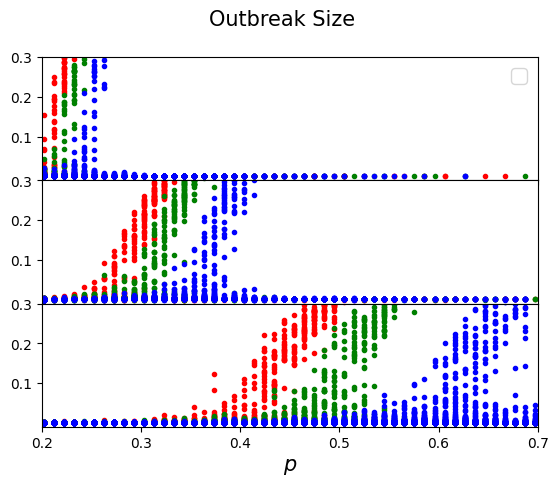

In [4]:
average_degree = 6 
c_1_list = [2,3,4]

p_range = np.linspace(0.1,0.70, 40)
alphas =  [0 , .25, 0.5]

ens = 100 
N = 10**5 # as stated in paper N is approx 10^5

# fig = plt.figure()
# gs = fig.add_gridspec(3, hspace=0)
# axs = gs.subplots(sharex=True, sharey=True)
Gs = [regular_clique(N, average_degree, c) for c in c_1_list]

for _al in range(len(alphas)):
    
    CT = lambda p_range, G, alpha: [contact_tracing(G, alpha, p)[4] for p in p_range]

    # Begin Original Code
    #  data = [np.mean(np.array(Parallel(n_jobs = max(12, multiprocessing.cpu_count()))(delayed(CT)(p_range, G, alphas[_al]) for en in range(ens))), axis = 0) for G in Gs]
    # End Original Code
    
    # Begin Adapted Code
    data = [np.array(Parallel(n_jobs = max(40, multiprocessing.cpu_count()))(delayed(CT)(p_range, G, alphas[_al]) for en in range(ens))) for G in Gs]
    # End Adapted Code

    np.save(str(N)+'_'+str(alphas[_al])+'_unprocessed_fig3A', data)
    
#     colors = ['r', 'g', 'b', 'm'] 
#     axs[_al].plot(p_range, data[0], marker ='*', label = r'$c = 2$', color = colors[0])
#     axs[_al].plot(p_range, data[1], marker = 6, label =r'$c = 3$', color = colors[1])
#     axs[_al].plot(p_range, data[2], marker= 'h', label = r'$c = 4$', color = colors[2])
#     if _al == 2:
#         axs[_al].set_yticks([.1, .2, .3])
#     else:
#         axs[_al].set_yticks([0, .1, .2])
#     axs[_al].set_ylim(-0.01, .3)
#     axs[_al].set_xlim(0.2, .7)
#     axs[_al].set_xlabel(r'$p$', fontsize = 15)

# axs[0].legend(fontsize = 15)
# fig.suptitle(r'Outbreak Size', fontsize = 15)
# plt.savefig(str(N)+'_'+str(alphas)+'_fig3A.pdf')    

## Loading from data

FileNotFoundError: [Errno 2] No such file or directory: '100000_0_regular.npy'

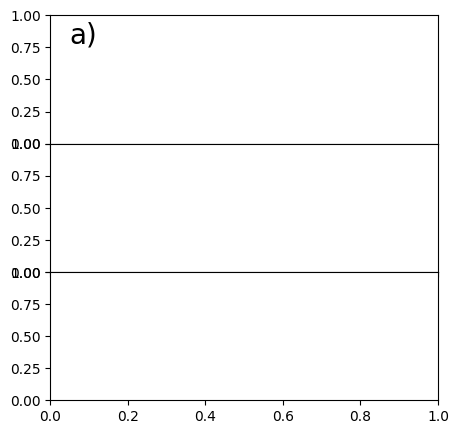

In [5]:
ens = 10**4
N = 10**5
average_degree = 6 
c_1_list = [2,3,4]
alphas =  [0   , .25, 0.5]

p_ranges = [np.linspace(0.1,0.30, 25), np.linspace(0.2,0.45, 30), np.linspace(0.3,0.7, 40)]

fig = plt.figure(figsize=(5, 5))
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True, sharey=True)

labels = ['a)', 'b)', 'c)', 'd)']
for _al in range(len(alphas)):
    axs[_al].text(0.05, 0.95, labels[_al], transform=axs[_al].transAxes, fontsize=20, va='top')

    CT = lambda p_range, G, alpha: [contact_tracing(G, alpha, p)[4] for p in p_range]
    data = [np.array(Parallel(n_jobs = max(50, multiprocessing.cpu_count()))(delayed(CT)(p_range, G, alphas[_al]) for en in range(ens))) for G in Gs]
    # data = np.load(str(N)+'_'+str(alphas[_al])+'_regular.npy')
    
    colors = ['r', 'g', 'b', 'm'] 
    axs[_al].plot(p_ranges[_al], data[0], marker ='*', label = r'$c = 2$', color = colors[0])
    axs[_al].plot(p_ranges[_al], data[1], marker = 6, label =r'$c = 3$', color = colors[1])
    axs[_al].plot(p_ranges[_al], data[2], marker= 'h', label = r'$c = 4$', color = colors[2])
    for cok in [0,1,2]:
        if _al == 2:
            axs[_al].plot(np.linspace(0.1,0.30, 15), [0 for _ in np.linspace(0.1,0.30, 15)], marker= 'h', label = r'$c = 4$', color = colors[cok])
        if _al == 1:
            axs[_al].plot(np.linspace(0.1,0.20, 15), [0 for _ in np.linspace(0.1,0.20, 15)], marker= 'h', label = r'$c = 4$', color = colors[cok])
        
    axs[_al].set_ylim(0, .1)
    axs[_al].tick_params(axis='y', labelsize=18)
    axs[_al].set_xlim(0.1, .7)
    axs[_al].set_xlabel(r'$p$', fontsize = 22)
    if _al==0:
        axs[_al].set_yticks([0.00, 0.05])

axs[0].legend(fontsize = 17)
axs[2].tick_params(axis='x', labelsize=18)
fig.text(-0.07, 0.5, 'Outbreak Size', ha='center', va='center', rotation='vertical', fontsize = 22,)


#plt.savefig(str(N)+'_'+str(alphas)+'_f33.pdf',bbox_inches='tight')   
plt.savefig('3a.pdf',bbox_inches='tight')   
